In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import random
import copy
import cv2 as cv
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering

import plotly.express as px
import pandas as pd
import umap.umap_ as umap
import pickle
sys.path.append('../')
from vae_functions import *

g:\venvs\p39_un\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


images (310080, 2, 32, 32)
lacina (310080, 32, 32)


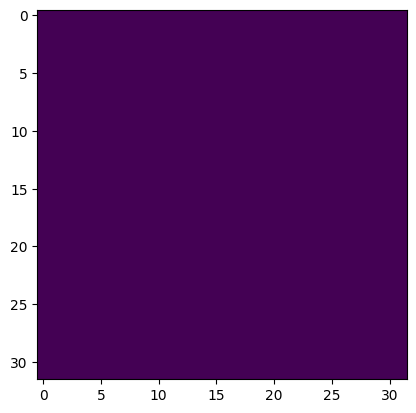

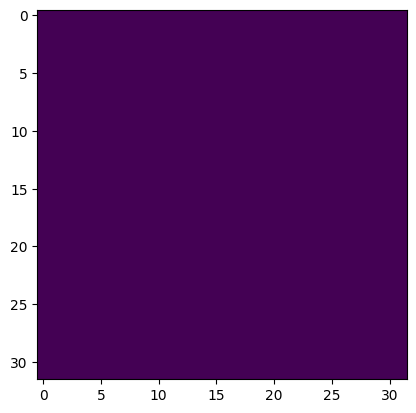

lacina (103886, 32, 32) --no spaces
lacina (103886, 32, 32, 1) --good shape


In [5]:
# cluster_hiragana = np.load("cluster_hiragana_35.npy")[:10000]
# cluster_latin = np.load("cluster_latin_37.npy")[:10000]
latin_datasets, hiragana_datasets = read_dataset_no_spaces(PATH)

latin_datasets = latin_datasets[:10000]
hiragana_datasets = hiragana_datasets[:10000]

path_to_page = 'E:/Studia/SIiUM/sem2/UNN/1_sign_per_class_no_distortions_whole_book/hiragana_img/hiragana_page_6.png'
path_to_page1 = 'E:/Studia/SIiUM/sem2/UNN/1_sign_per_class_no_distortions_whole_book/hiragana_img/hiragana_page_1.png'

hiragana_page = cv.imread(path_to_page, 0)
hiragana_page1 = cv.imread(path_to_page1, 0)

autoencoder_hiragana = read_vae('E:/Studia/SIiUM/sem2/UNN/vaeEncoder_hiragana', 'E:/Studia/SIiUM/sem2/UNN/vaeDecoder_hiragana')
autoencoder_latin = read_vae('E:/Studia/SIiUM/sem2/UNN/vaeEncoder_lacina', 'E:/Studia/SIiUM/sem2/UNN/vaeDecoder_lacina')



In [ ]:
filename_hiragana = 'E:/Studia/SIiUM/sem2/UNN/spec_hiragana_model.sav'
filename_latin = 'E:/Studia/SIiUM/sem2/UNN/spec_latin_model.sav'
loaded_model_latin = pickle.load(open(filename_latin, 'rb'))
loaded_model_hiragana = pickle.load(open(filename_hiragana, 'rb'))

In [14]:
def remap_to_lower_class(cluster: np.ndarray, length: int) -> np.ndarray:
    cluster = copy.deepcopy(cluster)
    min_number = length - 1
    max_number = np.max(cluster)
    # print(f"min_number: {min_number}, max_number: {max_number}")
    for i in range(min_number + 1, max_number + 1):
        if i <= np.max(cluster):
            # print(f"latin: {i}")
            cluster[cluster == i] = min_number

    return cluster[0]

def create_class_map(datasets: np.ndarray, labels: np.ndarray, length: int) -> dict:
    vals, counts = np.unique(labels, return_counts=True)
    # print(f"vals: {vals}")
    map_dict = {}
    for i, id in enumerate(vals):
        # if i > length: break
        # map_dict[id] = datasets[random.choice(np.argwhere(labels == id))].reshape(32,32)
        map_dict[id] = datasets[np.argwhere(labels == id)[0]].reshape(32,32)

    return map_dict

# def compere_map_length(map_latin, map_hiragana):
#     latin = copy.deepcopy(map_latin)
#     hiragana = copy.deepcopy(map_hiragana)
#     min_number = np.min([np.max(list(latin.keys())), np.max(list(hiragana.keys()))])
#     max_number = np.max([np.max(list(latin.keys())), np.max(list(hiragana.keys()))])

#     for i in range(min_number + 1, max_number + 1):
#         if i in list(latin.keys()):
#             del latin[i]
#         if i in list(hiragana.keys()):
#             del hiragana[i]
#     return latin, hiragana
def show_3d(predictions, labels):
    data_3d = umap.UMAP(n_neighbors = 10, min_dist = 0.1, n_components = 3, n_epochs = 300, metric = 'correlation').fit_transform(predictions)
    df = pd.DataFrame(data_3d, columns = ['x', 'y', 'z'])
    fig = px.scatter_3d(df, x = 'x', y = 'y', z = 'z', color = labels, color_continuous_scale = "jet", width = 1000, height = 800)
    fig.update_traces(marker = dict(size = 1))
    fig.show()

def generate_decode_list(labels_latin: np.ndarray, labels_hiragana: np.ndarray) -> list:
    vals_latin, counts_latin = np.unique(labels_latin, return_counts=True)
    print(f"vals_latin: {vals_latin}, counts_latin: {counts_latin}")
    latin_sorted, _ = zip(*sorted(zip(vals_latin, counts_latin), key = lambda x:x[1]))
    latin_sorted = latin_sorted[::-1]
    vals_hiragana, counts_hiragana = np.unique(labels_hiragana, return_counts=True)
    print(f"vals_hiragana: {vals_hiragana}, counts_hiragana: {counts_hiragana}")

    hiragana_sorted, _ = zip(*sorted(zip(vals_hiragana, counts_hiragana), key = lambda x:x[1]))
    hiragana_sorted = hiragana_sorted[::-1]

    hiragana_to_latin = {}
    print(f"latin_sorted: {latin_sorted}")
    print(f"hiragana_sorted: {hiragana_sorted}")
    for i in range(len(hiragana_sorted)):
        if len(latin_sorted) < i:
            hiragana_to_latin[hiragana_sorted[i]] = latin_sorted[len(hiragana_sorted)]
        else:
            hiragana_to_latin[hiragana_sorted[i]] = latin_sorted[i]
    print(f"hiragana_to_latin: {hiragana_to_latin}")
    
    return hiragana_to_latin

def find_space_id(datasets: np.ndarray, noise: bool) -> np.ndarray:
    space_id = []
    mark_id = []
    coef = 0.1 if noise else 0.05
    for i in range(len(datasets)):
        value, count = np.unique(datasets[i], return_counts= True)
        # print(count, value, count[0]/count[-1] )
        # if count[0]/count[-1] > coef or count[0] == count[-1]:
        if count[0] == count[-1]:
            space_id.append(i)
        else:
            mark_id.append(i)
        # plt.imshow(dataset[i], cmap='binary')
        # plt.show()
    return np.array(mark_id), np.array(space_id)

def cut_page(page: np.ndarray, dataset: list = None):
    column_num = 80
    row_num = 114
    letter_size = 32
    dataset = []

    for row in range(row_num):
        for column in range(column_num):
            # print(f"row_num*letter_size:row_num*letter_size + letter_size: {row*letter_size} {row*letter_size + letter_size}")
            # print(f"column_num*letter_size:column_num*letter_size + letter_size: {column*letter_size} {column*letter_size + letter_size}")
            letter = page[row*letter_size:row*letter_size + letter_size, column*letter_size:column*letter_size + letter_size]
            dataset.append(letter)

    return np.array(dataset)

def spectral_clustering(predictions) -> np.ndarray:
    # spec_model = SpectralClustering(n_clusters = 35)
    spec = SpectralClustering(n_clusters = 35, n_init = 100, random_state= 1)

    predicted_classes = spec.fit_predict(predictions)
    show_3d(predictions, predicted_classes)

    return predicted_classes

def cluster_dataset(hiragana_datasets, latin_dataset, encoder_hiragana: VAE,  encoder_latin: VAE, hiragana_dataset_page: np.ndarray, num_cluster: int = 35):

    #hiragana
    data_hiragana = np.zeros((hiragana_dataset_page.shape[0] + hiragana_datasets.shape[0], 32, 32, 1))
    data_hiragana[:hiragana_dataset_page.shape[0]] = hiragana_dataset_page[:,:,:,np.newaxis]
    data_hiragana[hiragana_dataset_page.shape[0]:] = hiragana_datasets
    data_hiragana[data_hiragana == 255] = 1

    # hiragana_datasets = np.append(hiragana_datasets, dataset).reshape(dataset.shape[0] + hiragana_datasets.shape[0], 32,32)
    _, _, pred_hiragana = encoder_hiragana.encoder.predict(data_hiragana, verbose = 0)

    cluster_hiragana = spectral_clustering(pred_hiragana)

    #latin
    latin_dataset[latin_dataset == 255] = 1

    _, _, pred_latin = encoder_latin.encoder.predict(latin_dataset, verbose = 0)

    cluster_latin = spectral_clustering(pred_latin) 

    return cluster_hiragana, cluster_latin

def descrypt_page(page: np.ndarray, page_cluster_label: np.ndarray, latin_dict: dict, hiragana_to_latin: dict, mark_id: list) -> np.ndarray:
    column_num = 80
    row_num = 114
    letter_size = 32
    page_latin = copy.deepcopy(page)
    space = np.ones((32,32)) * 255
    label_number = 0
    iter = 0
    for row in range(row_num):
        for column in range(column_num):
            if iter in mark_id:
                print(f"iter: {iter}, label_number: {label_number}, page_cluster_label[label_number]: {page_cluster_label[label_number]}, hiragana_to_latin[page_cluster_label[label_number]]: {hiragana_to_latin[page_cluster_label[label_number]]}")
                page_latin[row*letter_size:row*letter_size + letter_size, column*letter_size:column*letter_size + letter_size] = latin_dict[hiragana_to_latin[page_cluster_label[label_number]]]
                label_number += 1
            else:
                page_latin[row*letter_size:row*letter_size + letter_size, column*letter_size:column*letter_size + letter_size] = space
            iter += 1
    return page_latin

In [5]:
spec = SpectralClustering(n_clusters = 35, n_init = 100, random_state= 1)
hiragana_datasets[hiragana_datasets == 1] = 255

_, _, pred = autoencoder_hiragana.encoder.predict(hiragana_datasets, verbose = 0)
# predicted_classes = spec.fit(pred)
predicted_classes = spec.fit_predict(pred)

show_3d(pred, predicted_classes)

g:\venvs\p39_un\lib\site-packages\sklearn\manifold\_spectral_embedding.py:259: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



: 

: 

In [ ]:
# cluster_latin_lower = remap_to_lower_class(cluster_latin[np.newaxis], 35)
# print(f"max(cluster_latin_lower): {np.max(cluster_latin_lower)}")
# cluster_hiragana_lower = remap_to_lower_class(cluster_hiragana[np.newaxis], 35)
# print(f"max(cluster_hiragana_lower): {np.max(cluster_hiragana_lower)}")

# latin_lower = np.array(np.unique(cluster_latin_lower, return_counts=True)).T
# hiragana_lower = np.array(np.unique(cluster_hiragana_lower, return_counts=True)).T

vals_latin: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36], counts_latin: [ 488    2  670  919    6   36    8  886    2   28 1082  168    2   24
    5  255  239   37  444   96  747   42  270    7    2  557  737  385
   32  183  212  157  364  699  162   24   23]
vals_hiragana: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34], counts_hiragana: [ 258  670    5  672   11 1085   29  916  161  736  557    9  747  236
  215   21  211  872  211   45   32    3  444   37  363  384  697   35
    8  170    9   95    8   24   24]
latin_sorted: (10, 3, 7, 20, 26, 33, 2, 25, 0, 18, 27, 32, 22, 15, 16, 30, 29, 11, 34, 31, 19, 21, 17, 5, 28, 9, 35, 13, 36, 6, 23, 4, 14, 24, 12, 8, 1)
hiragana_sorted: (5, 7, 17, 12, 9, 26, 3, 1, 10, 22, 25, 24, 0, 13, 14, 18, 16, 29, 8, 31, 19, 23, 27, 20, 6, 34, 33, 15, 4, 30, 11, 32, 28, 2, 21)
hiragana_to_latin: {5: 10, 7: 3, 17: 7, 12: 20, 9

In [ ]:
for i in range(35):
    print(f"i: {i}")
    plt.imshow(map_latin[i])
    plt.show()

In [6]:
dataset_hiragana = cut_page(hiragana_page)
# dataset_hiragana = cut_page(hiragana_page1, list(dataset_hiragana_0))
dataset_hiragana[dataset_hiragana == 1] = 255
mark_id, space_id = find_space_id(dataset_hiragana, False)
cluster_hiragana, cluster_latin = cluster_dataset(hiragana_datasets, latin_datasets, autoencoder_hiragana, autoencoder_latin,  dataset_hiragana[mark_id], 35)



In [15]:
hiragana_to_latin = generate_decode_list(cluster_latin[:10000,np.newaxis], cluster_hiragana[:,np.newaxis])
latin_datasets[latin_datasets == 1] = 255
hiragana_datasets[hiragana_datasets == 1] = 255
map_latin = create_class_map(latin_datasets, cluster_latin[:10000], 35)
map_hiragana = create_class_map(hiragana_datasets, cluster_hiragana[:10000], 35)

vals_latin: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34], counts_latin: [1491    2    3   24    2    5  443  726   36  927    3  272  256 1080
  924  169    3  183  669   97   33  237    8  156   24  557  386   30
  212    2  364  488    3   24  161]
vals_hiragana: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34], counts_hiragana: [  43  972 1524    9   13  771   22   43    3  359  999  908 1237  236
   21 1211   40   78 1023  255  561  578  954  326   40  238   14  232
  454   14  277  126   60   26   13]
latin_sorted: (0, 13, 9, 14, 7, 18, 25, 31, 6, 26, 30, 11, 12, 21, 28, 17, 15, 34, 23, 19, 8, 20, 27, 33, 24, 3, 22, 5, 32, 16, 10, 2, 29, 4, 1)
hiragana_sorted: (2, 12, 15, 18, 10, 1, 22, 11, 5, 21, 20, 28, 9, 23, 30, 19, 25, 13, 27, 31, 17, 32, 7, 0, 24, 16, 33, 6, 14, 29, 26, 34, 4, 3, 8)
hiragana_to_latin: {2: 0, 12: 13, 15: 9, 18: 14, 10: 7, 1: 18, 22: 25, 11

i: 0


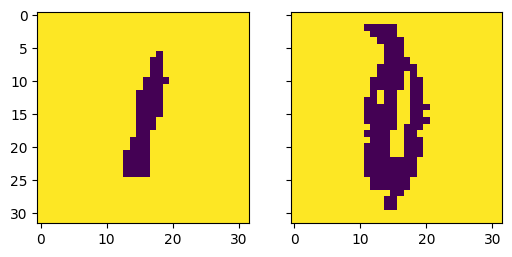

i: 1


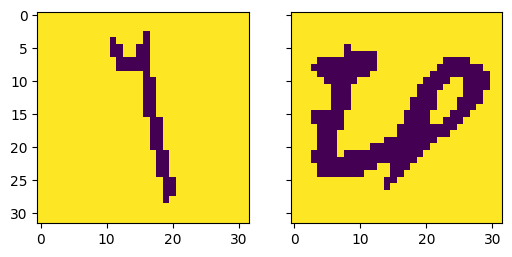

i: 2


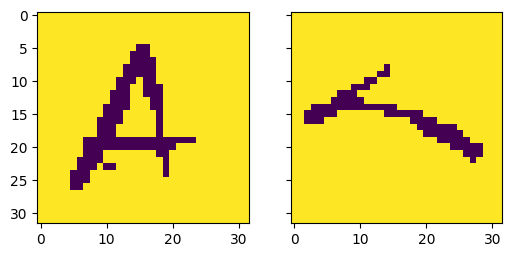

i: 3


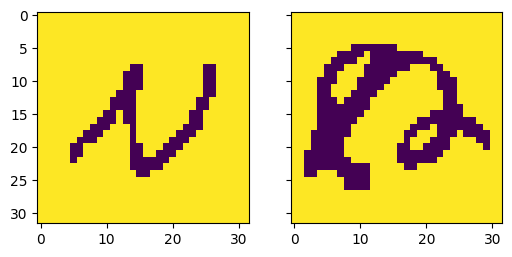

i: 4


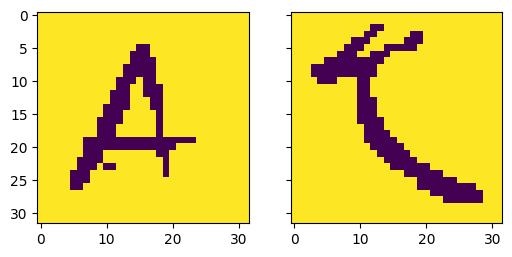

i: 5


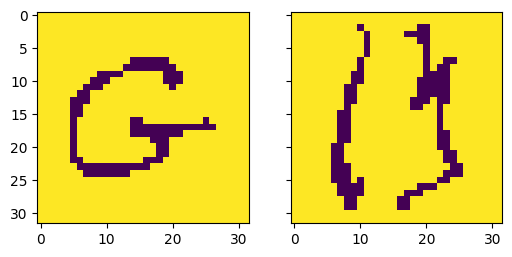

i: 6


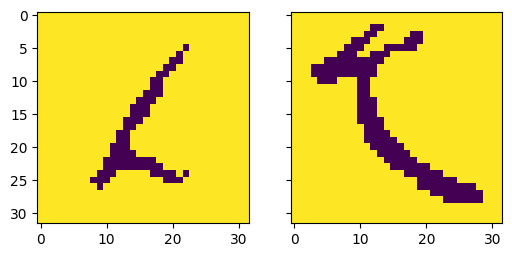

i: 7


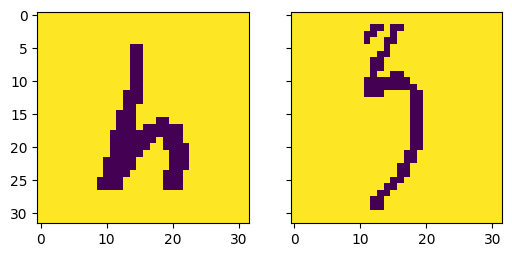

i: 8


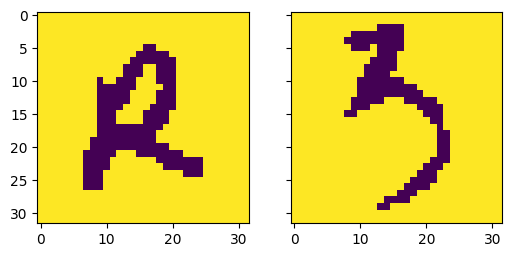

i: 9


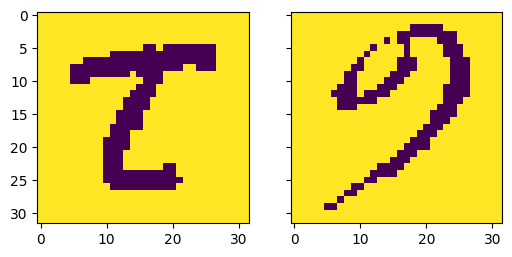

i: 10


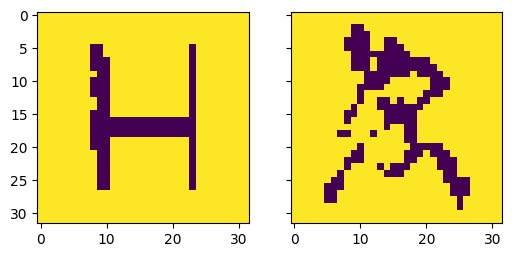

i: 11


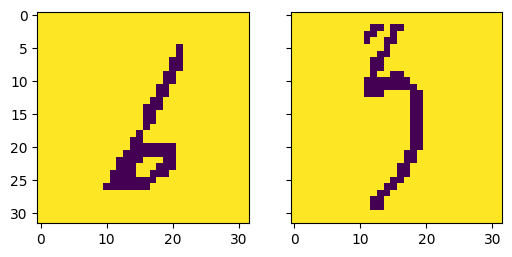

i: 12


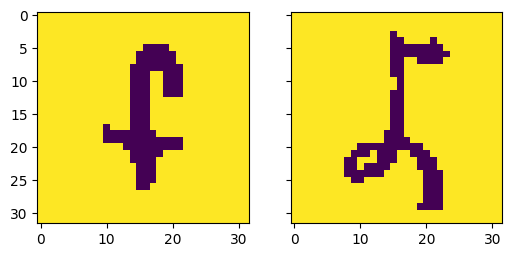

i: 13


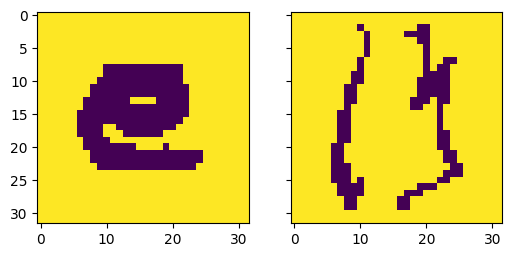

i: 14


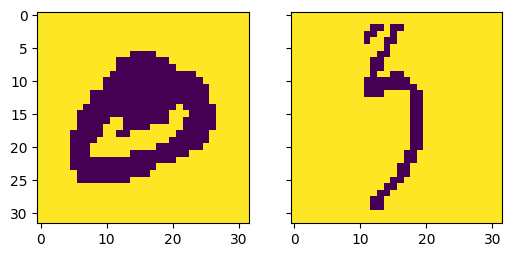

i: 15


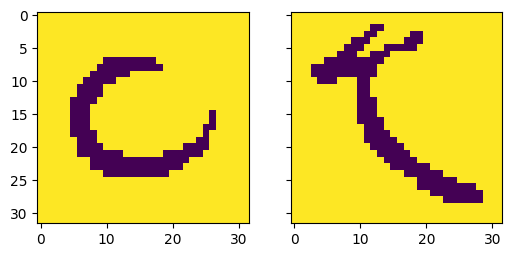

i: 16


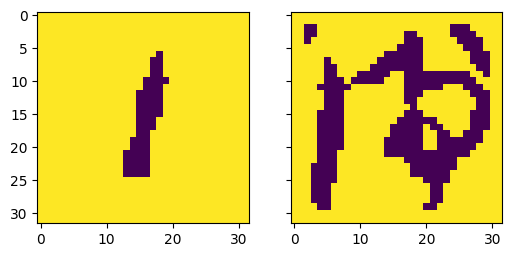

i: 17


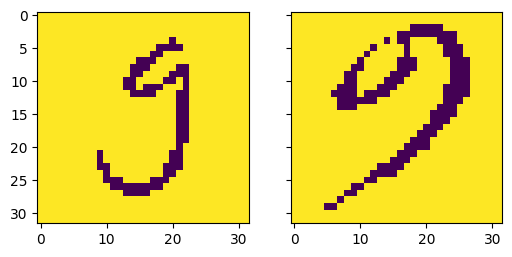

i: 18


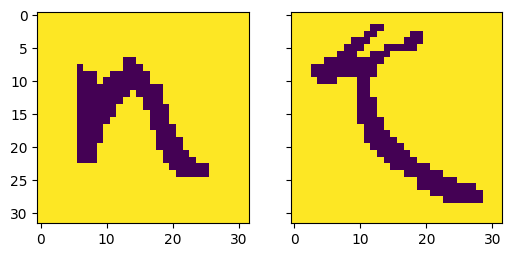

i: 19


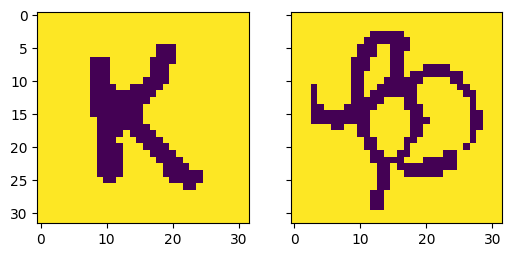

i: 20


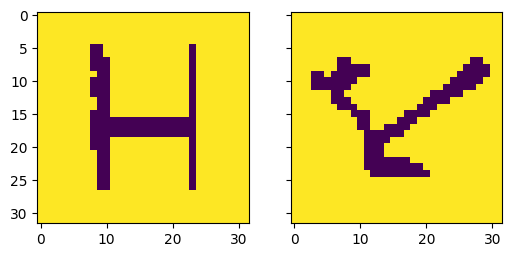

i: 21


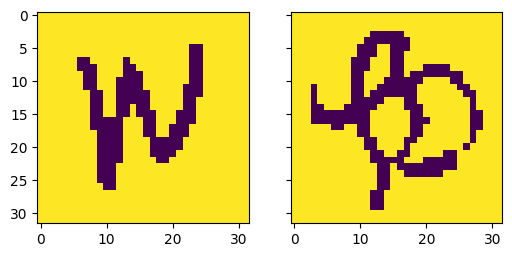

i: 22


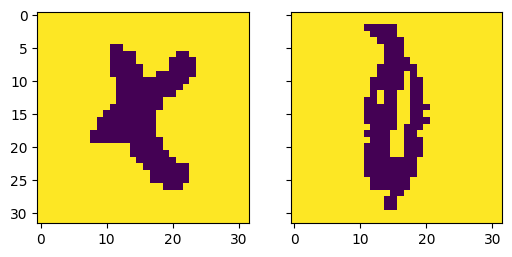

i: 23


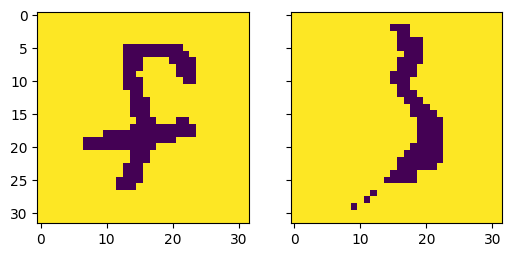

i: 24


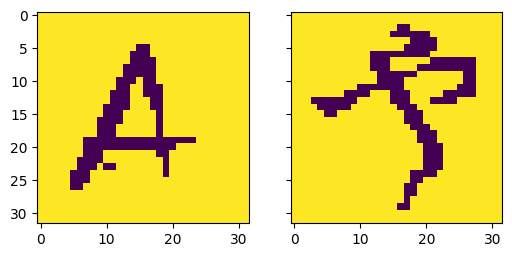

i: 25


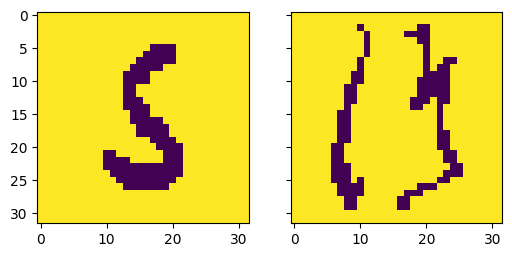

i: 26


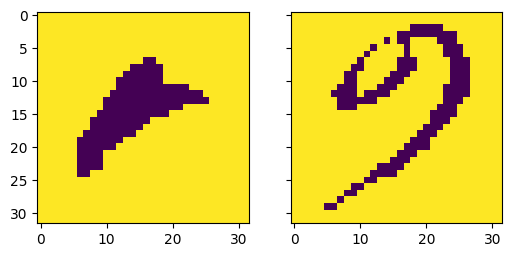

i: 27


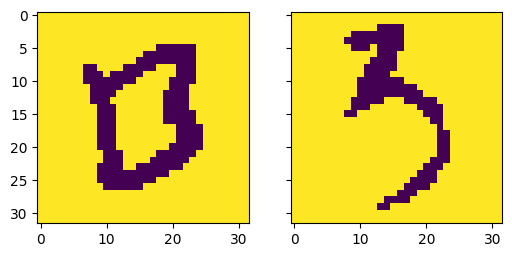

i: 28


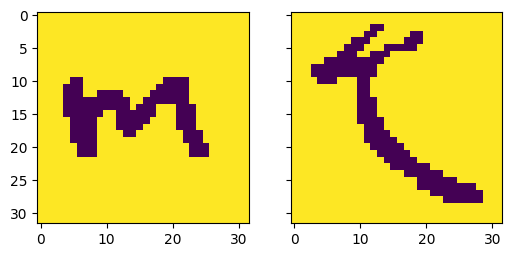

i: 29


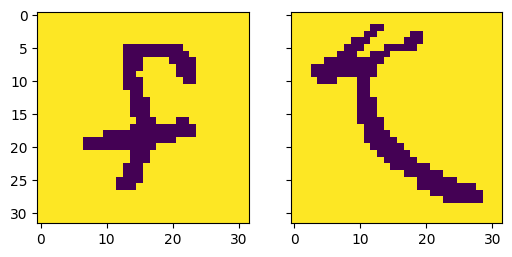

i: 30


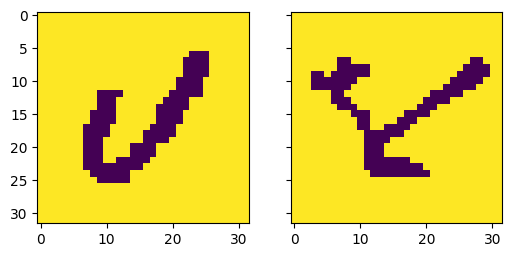

i: 31


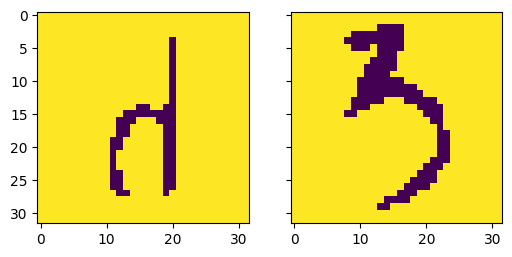

i: 32


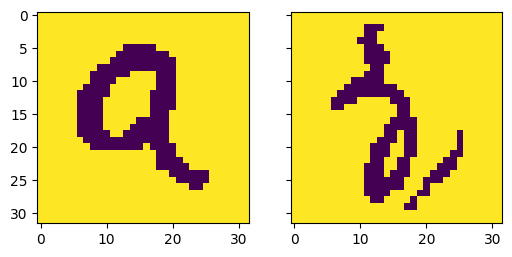

i: 33


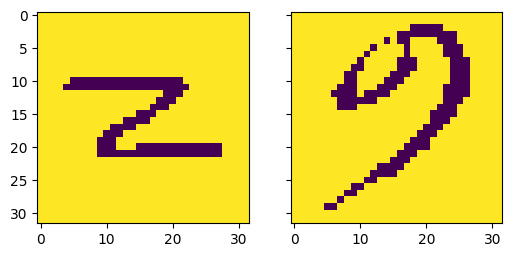

i: 34


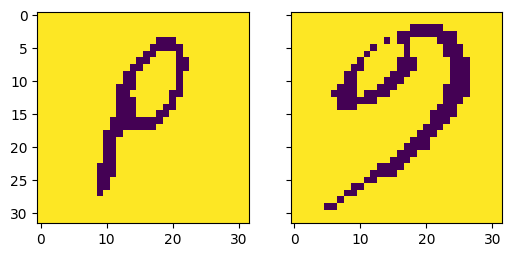

In [16]:
for i in range(35):
    print(f"i: {i}")
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6, 4))
    ax[0].imshow(map_latin[i])
    ax[1].imshow(map_hiragana[i])

    plt.show()

In [17]:
page_latin = descrypt_page(hiragana_page1, cluster_hiragana[10000:], map_latin, hiragana_to_latin, mark_id)

iter: 0, label_number: 0, page_cluster_label[label_number]: 2, hiragana_to_latin[page_cluster_label[label_number]]: 0
iter: 1, label_number: 1, page_cluster_label[label_number]: 9, hiragana_to_latin[page_cluster_label[label_number]]: 12
iter: 2, label_number: 2, page_cluster_label[label_number]: 5, hiragana_to_latin[page_cluster_label[label_number]]: 6
iter: 4, label_number: 3, page_cluster_label[label_number]: 10, hiragana_to_latin[page_cluster_label[label_number]]: 7
iter: 6, label_number: 4, page_cluster_label[label_number]: 31, hiragana_to_latin[page_cluster_label[label_number]]: 19
iter: 7, label_number: 5, page_cluster_label[label_number]: 10, hiragana_to_latin[page_cluster_label[label_number]]: 7
iter: 8, label_number: 6, page_cluster_label[label_number]: 19, hiragana_to_latin[page_cluster_label[label_number]]: 17
iter: 9, label_number: 7, page_cluster_label[label_number]: 27, hiragana_to_latin[page_cluster_label[label_number]]: 23
iter: 10, label_number: 8, page_cluster_label[l

In [ ]:
len(dataset_hiragana[mark_id])

In [ ]:
# page_latin = descrypt_page(hiragana_page, cluster_hiragana, map_latin, hiragana_to_latin, mark_id)


In [18]:
import matplotlib.image as mplimg

mplimg.imsave(f'test4.png',
                page_latin, cmap='gray')

In [ ]:
plt.imshow(page_latin[1000:2000, 1000:2000])
plt.show()